## XGBoost Model Develpment

#### Introduction to XGBoost
XGBoost (Extreme Gradient Boosting) is a powerful machine learning algorithm that implements the gradient boosting framework. It is widely used for its performance and efficiency in handling large-scale data, especially in structured/tabular data settings. XGBoost builds an ensemble of decision trees in a sequential manner to improve prediction accuracy.


In [42]:
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL


#### Data Preprocessing for XGBoost
The data preprocessing step involves encoding categorical features using `LabelEncoder`. This is crucial as XGBoost cannot directly handle categorical features. Each categorical feature is transformed into numerical labels.


In [43]:
def preprocess_data(data):
    # Encode categorical features
    label_encoders = {}
    categorical_columns = ['StockCode', 'Description', 'Country']
    
    for col in categorical_columns:
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])
        label_encoders[col] = le
    
    return data, label_encoders


#### Data Splitting
The dataset is split into training and testing sets. The features are separated from the target variable `TotalPrice`. The split is done using an 80-20 ratio, with 80% of the data used for training and 20% for testing.


In [44]:
def split_data(data):
    # Define your features and target variable
    X = data.drop(['TotalPrice', 'InvoiceDate'], axis=1)
    y = data['TotalPrice']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test


#### Hyperparameter Tuning
The `tune_xgboost` function performs a grid search to find the best hyperparameters for the XGBoost model. It explores different combinations of `max_depth`, `learning_rate`, and `n_estimators` to find the set of parameters that result in the lowest mean squared error (MSE) on the training data.


In [45]:
def tune_xgboost(X_train, y_train):
    param_grid = {
        'max_depth': [3, 5],
        'learning_rate': [0.01, 0.1],
        'n_estimators': [100, 200]
    }

    xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=2)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_xgb_model = grid_search.best_estimator_

    print(f'Best XGBoost parameters: {best_params}')
    print(f'Best XGBoost model MSE: {-grid_search.best_score_}')
    return best_xgb_model


#### Model Training
The `train_xgboost` function trains the XGBoost model using the best hyperparameters obtained from the grid search. It uses early stopping to prevent overfitting by monitoring the performance on the validation set.


In [46]:
def train_xgboost(X_train, y_train, X_test, y_test, best_params):
    # Remove objective from best_params if it exists
    best_params.pop('objective', None)
    
    model = xgb.XGBRegressor(objective='reg:squarederror', **best_params)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=10, verbose=True)
    return model


#### Plotting Learning Curves
The `plot_learning_curves` function visualizes the learning process by plotting the RMSE for both training and validation sets over each boosting round.


In [47]:
def plot_learning_curves(model):
    results = model.evals_result()
    epochs = len(results['validation_0']['rmse'])
    x_axis = range(0, epochs)
    
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
    ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
    ax.legend()
    plt.ylabel('RMSE')
    plt.title('XGBoost RMSE')
    plt.grid(True)
    plt.show()


#### Model Validation
The `validate_model` function evaluates the model's performance on the test set. It calculates several performance metrics including MAE, RMSE, MASE, and WMAPE.


In [48]:
def validate_model(model, X_test, y_test):
    predictions = model.predict(X_test)

    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mase = mae / np.mean(np.abs(np.diff(y_test)))
    wmape = np.sum(np.abs(predictions - y_test)) / np.sum(y_test)

    metrics = {
        'MAE (Total)': mae,
        'RMSE (Total)': rmse,
        'MASE (Total)': mase,
        'WMAPE (Total)': wmape
    }

    print("Validation Metrics:")
    for metric, value in metrics.items():
        print(f'{metric}: {value}')

    return metrics, predictions


#### Diagnostic Check
The `diagnostic_check` function plots the true values against the predictions to visually inspect the model's performance.


In [49]:
def diagnostic_check(y_test, predictions):
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.values, label='True Values')
    plt.plot(predictions, label='Predictions')
    plt.title('XGBoost Model - True vs Predictions')
    plt.xlabel('Time')
    plt.ylabel('Total Sales')
    plt.legend()
    plt.grid(True)
    plt.show()


#### Decompose Seasonal Component
The `decompose_seasonal_component` function decomposes the sales data into seasonal components using the STL (Seasonal and Trend decomposition using Loess) method.


In [50]:
def decompose_seasonal_component(data):
    data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
    data.set_index('InvoiceDate', inplace=True)
    daily_sales = data['TotalPrice'].resample('D').sum().fillna(0)
    stl = STL(daily_sales, seasonal=7)
    result = stl.fit()
    return result


#### Calculate Seasonal Metrics
The `calculate_seasonal_metrics` function calculates the Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) for the seasonal component.


In [51]:
def calculate_seasonal_metrics(model, X_test, y_test, seasonal_component):
    predictions = model.predict(X_test)

    # Ensure the lengths match
    if len(predictions) < len(seasonal_component):
        seasonal_component = seasonal_component[-len(predictions):]
    else:
        predictions = predictions[-len(seasonal_component):]

    smae = mean_absolute_error(seasonal_component, predictions)
    srmse = np.sqrt(mean_squared_error(seasonal_component, predictions))

    seasonal_metrics = {
        'MAE (Seasonal)': smae,
        'RMSE (Seasonal)': srmse
    }

    return seasonal_metrics


#### Plot Seasonal Comparisons
The `plot_seasonal_comparisons` function plots the true and predicted seasonal components.


In [52]:
def plot_seasonal_comparisons(y_test, predictions, seasonal_component):
    # Ensure the lengths match
    if len(predictions) < len(seasonal_component):
        seasonal_component = seasonal_component[-len(predictions):]
    else:
        predictions = predictions[-len(seasonal_component):]

    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index[-len(seasonal_component):], seasonal_component, label='True Seasonal')
    plt.plot(y_test.index[-len(predictions):], predictions, label='Predicted Seasonal')
    plt.title('True vs Predicted Seasonal Components')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True)
    plt.show()


#### Plot Seasonal Decomposition
The `plot_seasonal_decomposition` function plots the results of the STL decomposition.


In [53]:
def plot_seasonal_decomposition(stl_result):
    stl_result.plot()
    plt.show()


#### Main Function
The `main_xgboost` function orchestrates the data preprocessing, model training, hyperparameter tuning, validation, and diagnostics. It also logs the chosen hyperparameters and the calculated performance metrics.


In [54]:
def main_xgboost(file_path, metrics_df_path):
    data = pd.read_csv(file_path)
    data, label_encoders = preprocess_data(data)
    X_train, X_test, y_train, y_test = split_data(data)

    stl_result = decompose_seasonal_component(data)
    seasonal_component = stl_result.seasonal

    best_xgb_model = tune_xgboost(X_train, y_train)
    model = train_xgboost(X_train, y_train, X_test, y_test, best_xgb_model.get_params())
    plot_learning_curves(model)
    metrics, predictions = validate_model(model, X_test, y_test)
    diagnostic_check(y_test, predictions)

    seasonal_metrics = calculate_seasonal_metrics(model, X_test, y_test, seasonal_component)
    print(f'Seasonal Metrics: {seasonal_metrics}')
    plot_seasonal_comparisons(y_test, predictions, seasonal_component)
    plot_seasonal_decomposition(stl_result)

    # Load or create a metrics DataFrame
    try:
        metrics_df = pd.read_csv(metrics_df_path)
    except FileNotFoundError:
        metrics_df = pd.DataFrame(columns=['Model', 'MAE (Total)', 'RMSE (Total)', 'MASE (Total)', 'WMAPE (Total)', 'MAE (Seasonal)', 'RMSE (Seasonal)'])

    metrics['Model'] = 'XGBoost'
    metrics.update(seasonal_metrics)
    metrics_df = metrics_df.append(metrics, ignore_index=True)

    # Save the updated metrics DataFrame
    metrics_df.to_csv(metrics_df_path, index=False)
    print('Model performance metrics updated and saved to', metrics_df_path)


#### Run the Main Function
This block runs the `main_xgboost` function with the specified file paths.


Best XGBoost parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best XGBoost model MSE: 48589.204216822436
[0]	validation_0-rmse:221.36060	validation_1-rmse:206.58707
[1]	validation_0-rmse:211.30699	validation_1-rmse:205.65760
[2]	validation_0-rmse:201.78585	validation_1-rmse:204.81180
[3]	validation_0-rmse:192.86619	validation_1-rmse:204.11943
[4]	validation_0-rmse:184.50972	validation_1-rmse:203.52744
[5]	validation_0-rmse:176.63934	validation_1-rmse:203.02279
[6]	validation_0-rmse:169.23165	validation_1-rmse:202.62693


/Users/dacawave/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-rmse:162.28598	validation_1-rmse:202.25049
[8]	validation_0-rmse:155.79085	validation_1-rmse:201.94611
[9]	validation_0-rmse:149.69601	validation_1-rmse:201.65002
[10]	validation_0-rmse:143.91633	validation_1-rmse:201.38605
[11]	validation_0-rmse:138.55273	validation_1-rmse:201.15312
[12]	validation_0-rmse:133.54028	validation_1-rmse:201.00250
[13]	validation_0-rmse:128.78722	validation_1-rmse:200.78690
[14]	validation_0-rmse:124.40848	validation_1-rmse:200.64340
[15]	validation_0-rmse:119.88539	validation_1-rmse:200.49089
[16]	validation_0-rmse:115.99623	validation_1-rmse:200.33212
[17]	validation_0-rmse:112.41775	validation_1-rmse:200.21931
[18]	validation_0-rmse:108.83541	validation_1-rmse:200.14563
[19]	validation_0-rmse:105.55706	validation_1-rmse:199.98933
[20]	validation_0-rmse:102.65120	validation_1-rmse:199.86911
[21]	validation_0-rmse:99.88597	validation_1-rmse:199.77517
[22]	validation_0-rmse:97.27846	validation_1-rmse:199.66557
[23]	validation_0-rmse:94.945

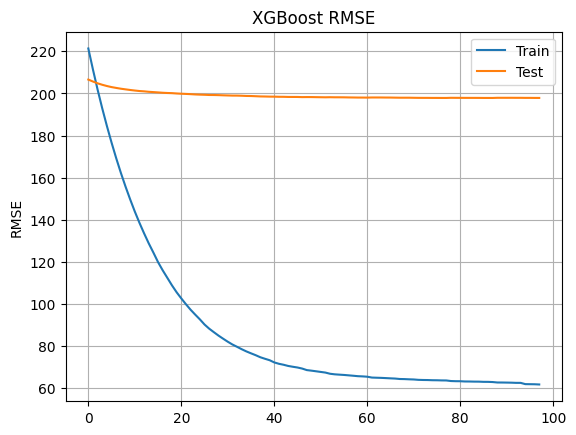

Validation Metrics:
MAE (Total): 5.86249601812254
RMSE (Total): 197.86126633184605
MASE (Total): 0.2079682924224225
WMAPE (Total): 0.2618548119824944


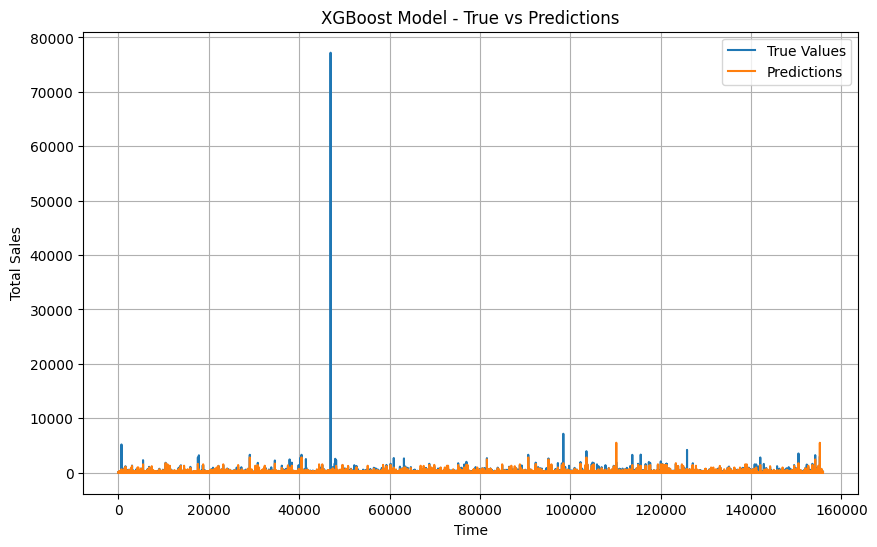

Seasonal Metrics: {'MAE (Seasonal)': 9159.449164632793, 'RMSE (Seasonal)': 12460.039498400856}


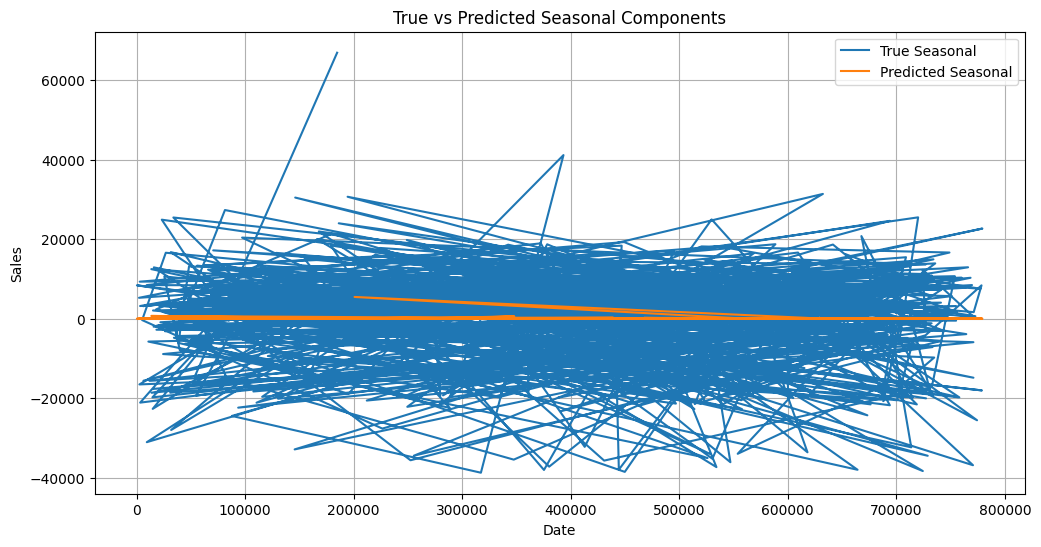

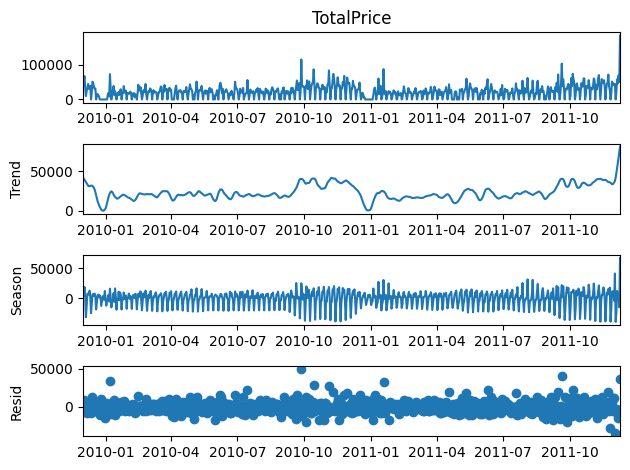

Model performance metrics updated and saved to model_performance_metrics.csv


/var/folders/x3/h0qgc64j0gs_982j8_34cq540000gp/T/ipykernel_5201/1141516478.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


In [55]:
file_path = 'preprocessed_data.csv'
metrics_df_path = 'model_performance_metrics.csv'
main_xgboost(file_path, metrics_df_path)
